In [2]:
df['Embeddings']

0       [0.229548112, 0.401379973, 0.709224641, -0.310...
1       [0.262241274, 0.416224033, 0.670677245, -0.301...
2       [0.262241274, 0.416224033, 0.670677245, -0.301...
3       [0.233746156, 0.41280815, 0.720358193, -0.3248...
4       [0.233746156, 0.41280815, 0.720358193, -0.3248...
                              ...                        
1073    [0.220761716, 0.411873817, 0.728400469, -0.310...
1074    [0.233884066, 0.419766098, 0.722747862, -0.319...
1075    [0.207574964, 0.384215593, 0.743888855, -0.324...
1076    [0.207574964, 0.384215593, 0.743888855, -0.324...
1077    [0.251417726, 0.434744626, 0.721360683, -0.324...
Name: Embeddings, Length: 1078, dtype: object

In [65]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# Load the Excel file into a DataFrame
file_path = 'unique_references.xlsx'
df = pd.read_excel(file_path)

# Specify the column containing the embeddings (replace 'Embeddings_Column' with the actual column name)
embeddings_column_name = 'Embeddings'


In [66]:
def parse_embeddings(embeddings_str):
    # Split the string by comma and remove any leading/trailing whitespace
    values = embeddings_str.strip('[]').split(',')
    # Convert the values to float and create a NumPy array
    return np.array([float(val) for val in values]).round(10)

df['Embeddings'] = df[embeddings_column_name].apply(parse_embeddings)

# Create a new DataFrame with the extracted embeddings as columns
embedding_df = pd.DataFrame(df['Embeddings'].tolist())


,Reference_Number
0,20221AGWA
1,FIN873DLGSCAG
2,02022021DLGSCPTT
3,RFQBPB202108
4,CRTF200001038
...,...
411,WAPOL05820
412,WAPOL15720
413,WAPOL13118A
414,WAPOL00119


Create a excel file with fewer values (such as ref_number , contract_title, Description , Cluster_grp)

Scale the data before appying DBSCAN 

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(embedding_df)

In [49]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.10, min_samples=5)  # Adjust parameters as needed
#cluster_labels = dbscan.fit_predict(embedding_df)

# Add the cluster labels to the original DataFrame
df['Cluster_Label'] = cluster_labels

# Save the updated DataFrame to a new Excel file
#updated_file_path = 'updated_excel_file.xlsx'
#df.to_excel(updated_file_path, index=False)

# Print the cluster labels
#print("Cluster labels:")
#print(cluster_labels)

cluster =[]

for k in range(1,20):
    
    model = DBSCAN(eps=k*0.1)
    
    
    cluster_labels = model.fit_predict(embedding_df)
    
    
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

    # Print the cluster labels and their counts
    for label, count in zip(unique_labels, label_counts):
        print(f"Cluster {label}: {count} instances")
#plt.plot(range(2,9),ssd,'o--')
#plt.xlabel("K Value")
#plt.ylabel(" Sum of Squared Distances");

Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances
Cluster -1: 408 instances
Cluster 0: 8 instances


In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

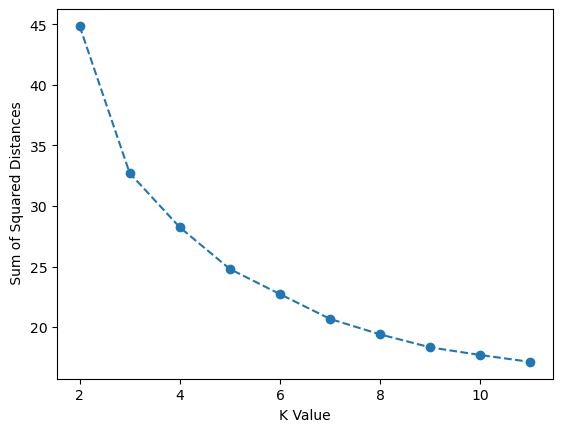

In [69]:
warnings.filterwarnings("ignore", category=UserWarning)
ssd = []

for k in range(2,12):
    
    model = KMeans(n_clusters=k,random_state=5508)
    
    
    model.fit(embedding_df)
    
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)
plt.plot(range(2,12),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances");

C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

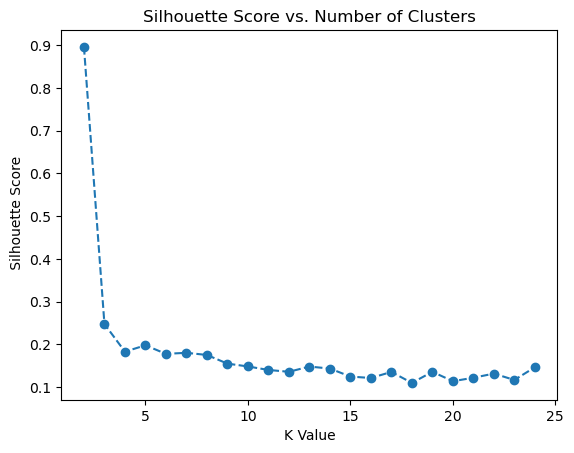

In [74]:
# Ignore the warning
warnings.filterwarnings("ignore", category=UserWarning)
# define range of K values
k_range = range(2, 25)

# empty list to store silhouette scores for each K
silhouette_scores = []

# loop over K values
for k in k_range:
    # fit K-means model
    kmeans = KMeans(n_clusters=k, random_state=5508).fit(embedding_df)
    # compute silhouette score
    score = silhouette_score(embedding_df, kmeans.labels_, metric='euclidean')
    silhouette_scores.append(score)
plt.plot(k_range,silhouette_scores,'o--')
plt.xlabel("K Value")
plt.ylabel(" Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.show()

C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

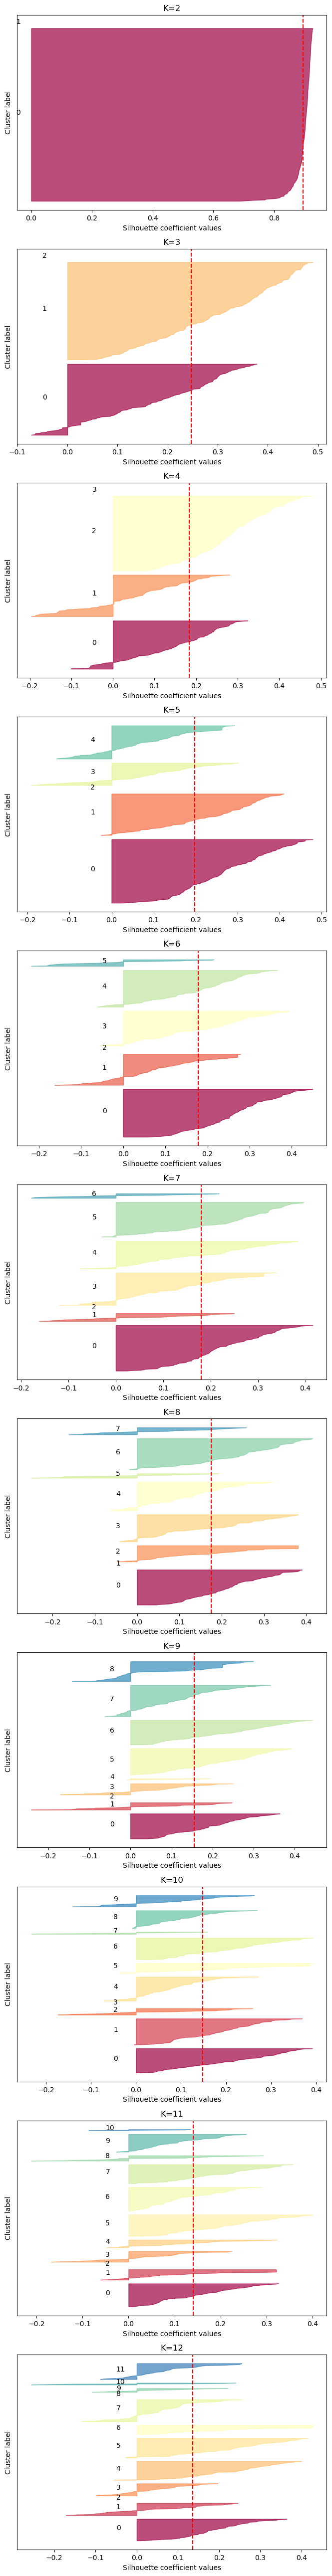

In [75]:
#Using silhouette analysis to find optimal K value

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Set random state
np.random.seed(5508)

# Define the range of K values
K_values = range(2, 13)

# Initialize a list to store the silhouette scores
silhouette_scores = []

# Create a subplot for each K value
fig, axs = plt.subplots(len(K_values), 1, figsize=(8, 6 * len(K_values)))

# Iterate over the range of K values
for i, K in enumerate(K_values):
    # Fit the K-means model
    kmeans = KMeans(n_clusters=K, random_state=5508)
    kmeans.fit(embedding_df)

    # Obtain the cluster labels
    labels = kmeans.labels_

    # Compute the silhouette score
    silhouette_avg = silhouette_score(embedding_df, labels)
    silhouette_scores.append(silhouette_avg)

    # Plot the silhouette diagram
    ax = axs[i]
    y_lower = 10

    for j in range(K):
        # Collect silhouette scores for samples in the current cluster
        cluster_silhouette_scores = silhouette_samples(embedding_df, labels)[labels == j]
        cluster_silhouette_scores.sort()

        size_cluster_j = cluster_silhouette_scores.shape[0]
        y_upper = y_lower + size_cluster_j

        color = plt.cm.get_cmap("Spectral")(j / K)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the cluster with its silhouette score
        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"K={K}")


In [77]:
# Perform DBSCAN clustering
kmeans = KMeans(n_clusters=K, random_state=5508)
cluster_labels = kmeans.fit_predict(embedding_df)

# Add the cluster labels to the original DataFrame
df['Cluster_Label'] = cluster_labels

# Save the updated DataFrame to a new Excel file
updated_file_path = 'updated_excel_file.xlsx'
df.to_excel(updated_file_path, index=False)

# Print the cluster labels
print("Cluster labels:")
print(cluster_labels)

C:\Users\skena\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster labels:
[ 7 11  5  0  4  3  1  5  5 11  0  6  5 11  5  0  5  4  4  1  0  4  9  0
  1  5  5 11  0  4  7  9  3  7  1 11 11  4  0  4  0  5  5 11  4  7  7  4
  4  1  7 11  1 11  8  7  4  7  1  7  1  1  5  4  7  0  7  5  5 11  1  7
  7  4  0  7  7  7  7  7 11  7  1  4  4  1 11  0  0 11  6  0 11  7  7  1
  0  3  7  4  0  1  4  0 11 11 11  7  1  7  7  5  5  7  0  5  5 11  1  5
  1  6  6  0  1  6  6  6  6  6  6  3  6  6  6  7  4  1  0  4  0  0  5  5
  0  3 10  9  6  0  6  6  3  3  7  6  0  0  0  5  3  4  4  6  5 11  2 11
  4  4 11 11 11  0  6 10  0  6  3  7  5  6  9  5  4  1  1 11  1  1  5  5
  4  4  4  3  4  0  4  5  3  4  0  1  3  7  4  9  3  0  5  1  1  5  0  1
 11  4  4  5 11  7  5  5  0  3  4  1  7  7  0  4  7  7  3  6  7  3  7  7
  3  7  0  3  4  7  7  4  6  7  7  4  7  3  3  6 10  0  3  9  9  1 10  3
 11 11 11  0  1  3  0  7  5  4  3  4 11  0  1  7  0  5  7  5  4  3  7  6
  4  4  5  7  3 11  0  3  7  5  4  0  5  5 11  1  0  7 11  3 11  5  9  9
  9  3  9  4  7  7  4  1 10  0  0  

In [78]:
import pandas as pd

# Load the original Excel file into a DataFrame
file_path = 'updated_excel_file.xlsx'
df = pd.read_excel(file_path)

# Specify the columns you want to keep (replace 'Column1' and 'Column2' with the actual column names)
columns_to_keep = ['Reference Number', 'Client Agency','Developing Agency Parent','Contract Title','Description','UNSPSC Title','Cluster_Label']

# Create a new DataFrame with only the specified columns
new_df = df[columns_to_keep]

# Save the new DataFrame to a new Excel file
new_file_path = 'cluster_file.xlsx'
new_df.to_excel(new_file_path, index=False)
